# Load some standard modules...

In [1]:
import os
import random

# List the working directory

In [2]:
os.listdir('.')

['stopsign_005.png',
 'stopsign_004.png',
 'stopsign_001.png',
 '.ipynb_checkpoints',
 'stopsign_003.png',
 'ContourClassification.ipynb',
 'stopsign_002.png']

# Import the data science modules

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

# Load our images and display them

In [4]:
images = []
for f in ['stopsign_001.png', 'stopsign_002.png', 'stopsign_003.png', 'stopsign_004.png', 'stopsign_005.png']:
    images.append(cv2.imread(f))

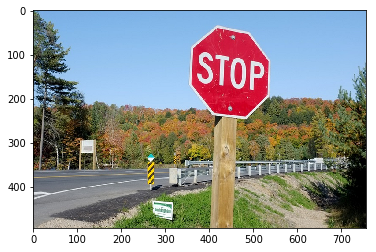

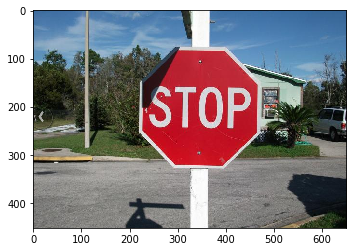

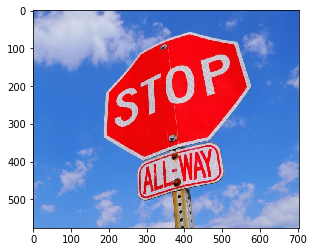

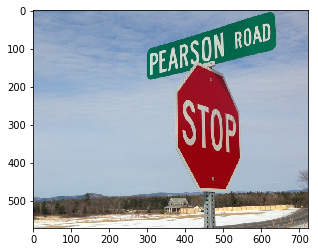

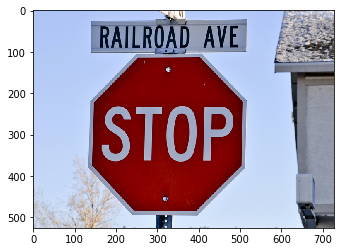

In [5]:
for im in images:
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()

# Basic edge detection with OpenCV

In [6]:
edge_images = []
for im in images:
    edge_images.append(cv2.Canny(cv2.blur(im, (5,5)), 150, 300))

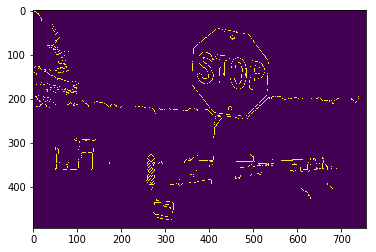

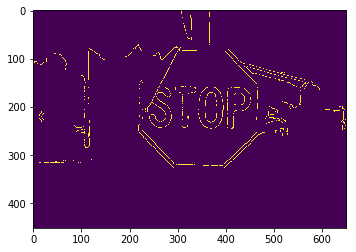

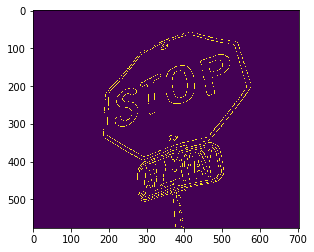

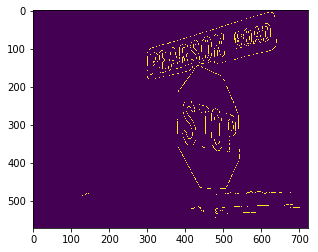

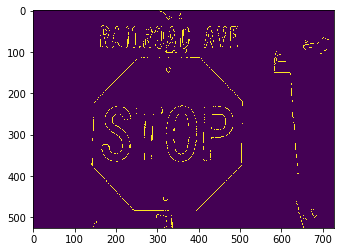

In [7]:
for eim in edge_images:
    plt.imshow(eim)
    plt.show()

# Draw the edges, linking together over narrow gaps

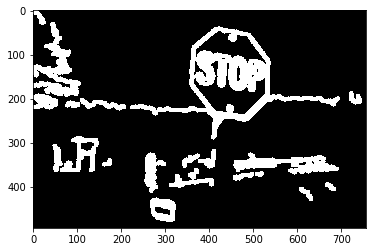

167


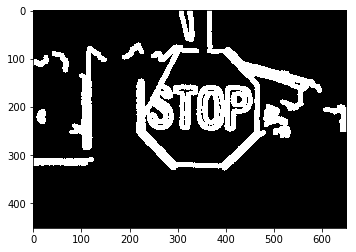

62


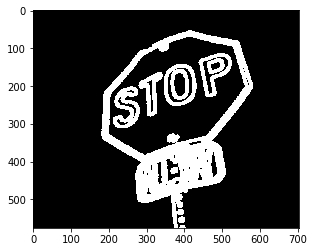

66


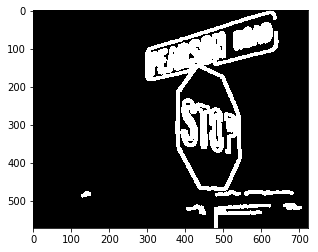

92


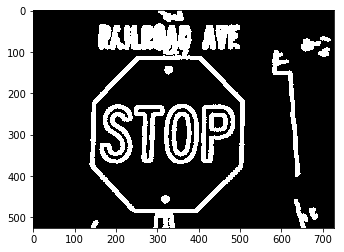

168


In [8]:
new_images = []
index = 0
for eim in edge_images:
    cont, hier = cv2.findContours(eim, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_image = np.zeros(images[index].shape, images[index].dtype)
    cv2.drawContours(new_image, cont, -1, (255, 255, 255), 10)
    new_image = cv2.erode(new_image, (5,5))
    new_images.append(new_image[:,:,:])
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    plt.show()
    print len(cont)
    index += 1

# Draw the edges with a unique color for each contour

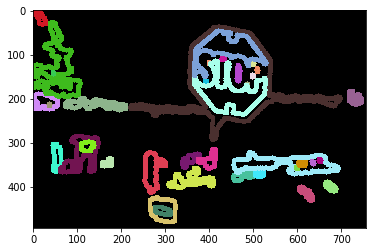

37


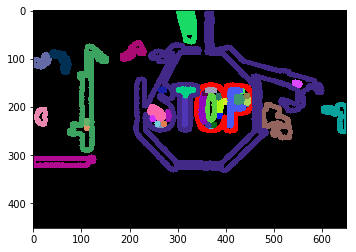

42


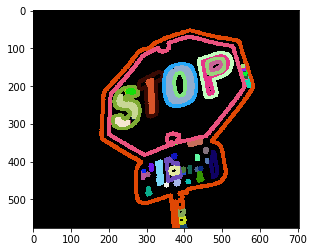

54


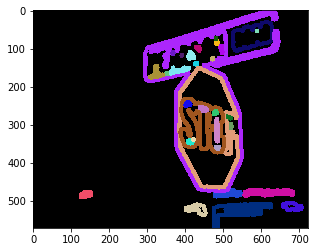

34


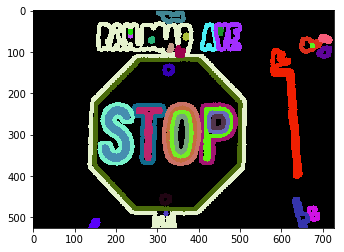

35


In [9]:
#Deterministic colors
random.seed(0)

index = 0
for eim in new_images:
    cont, hier = cv2.findContours(cv2.cvtColor(eim, cv2.COLOR_BGR2GRAY), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_image = np.zeros(eim.shape, images[0].dtype)
    for c in cont:
        cv2.drawContours(new_image, [c], -1, (random.randint(0,255), random.randint(0,255), random.randint(0,255)), 10)
    plt.imshow(new_image)
    plt.show()
    print len(cont)

# Display the useful contour features

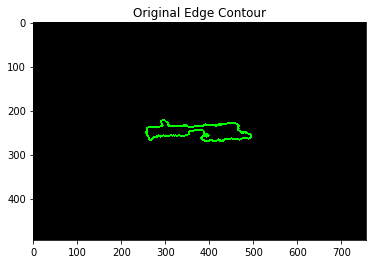

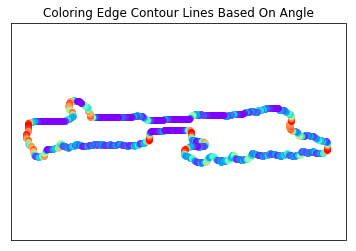

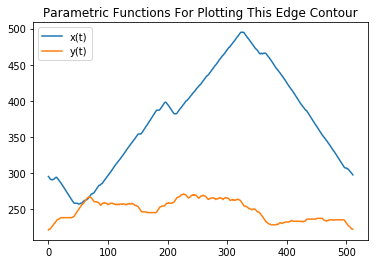


----------------------------------------------------------------------------



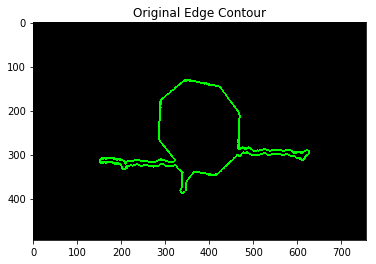

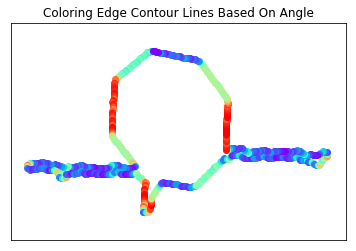

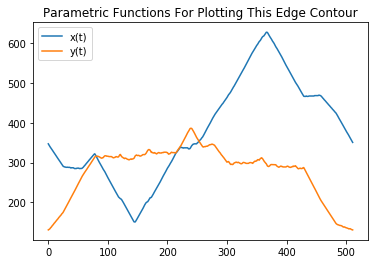


----------------------------------------------------------------------------



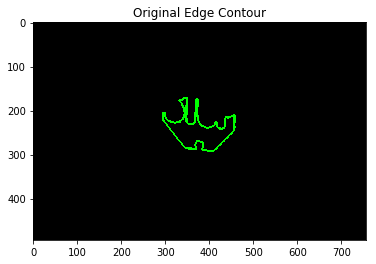

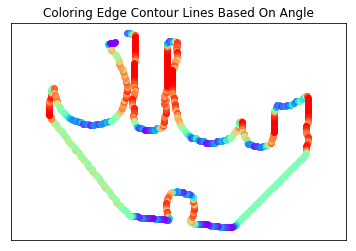

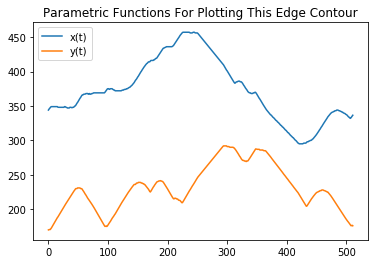


----------------------------------------------------------------------------



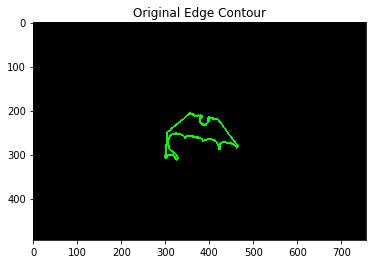

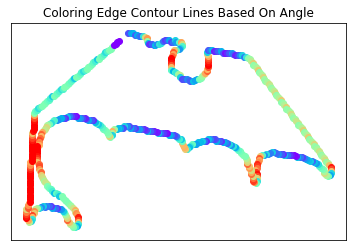

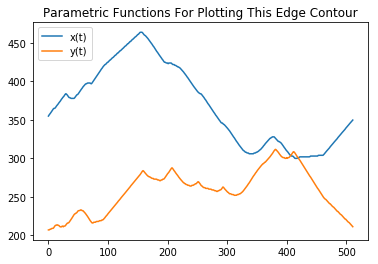


----------------------------------------------------------------------------



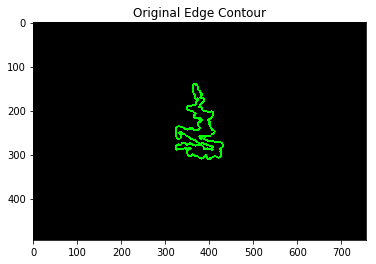

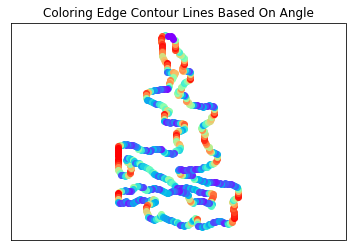

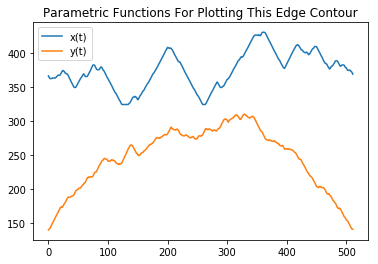


----------------------------------------------------------------------------



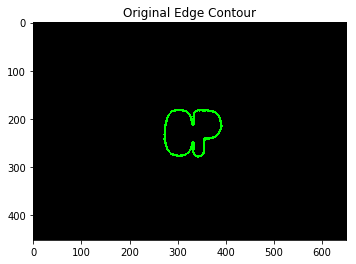

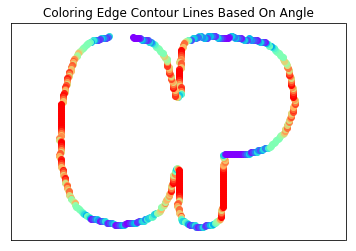

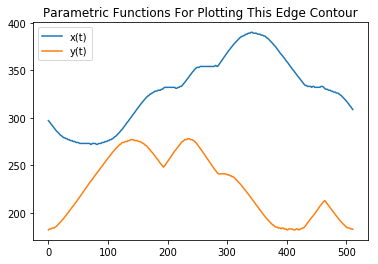


----------------------------------------------------------------------------



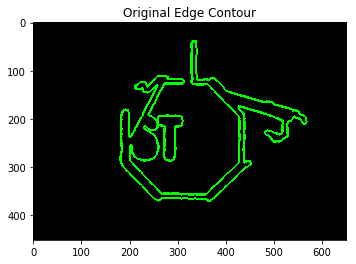

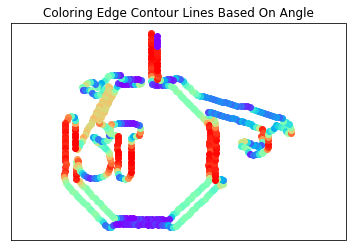

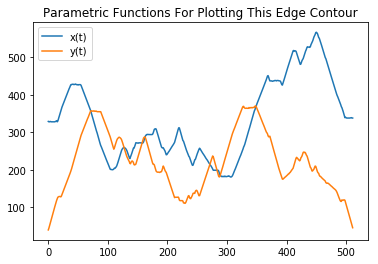


----------------------------------------------------------------------------



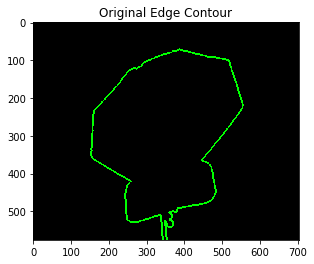

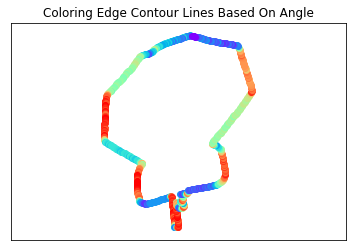

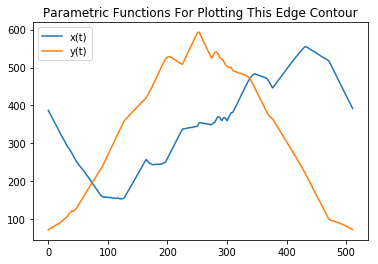


----------------------------------------------------------------------------



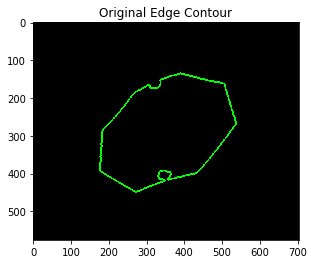

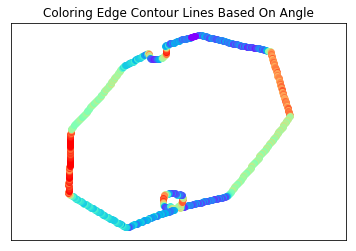

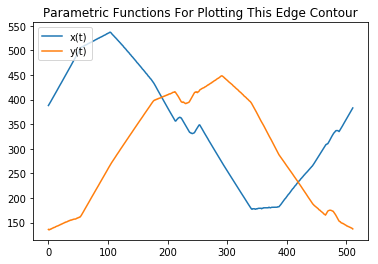


----------------------------------------------------------------------------



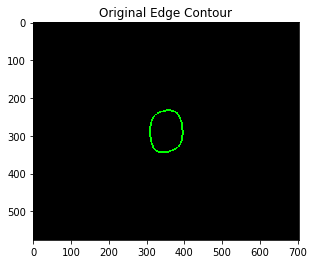

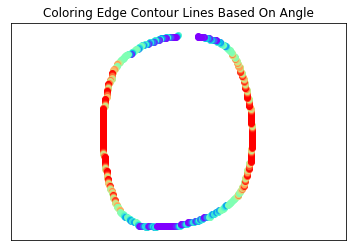

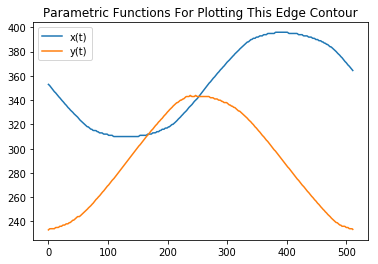


----------------------------------------------------------------------------



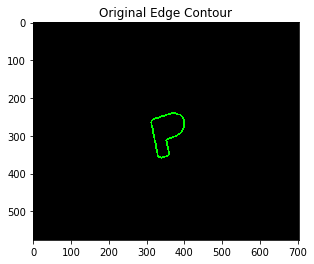

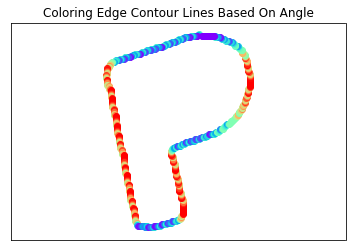

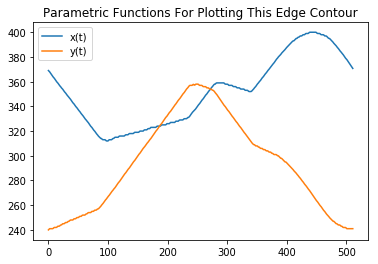


----------------------------------------------------------------------------



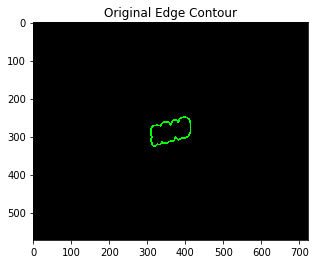

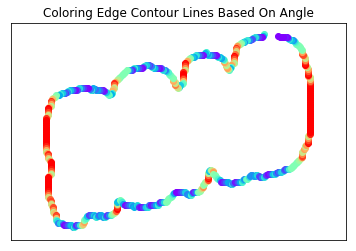

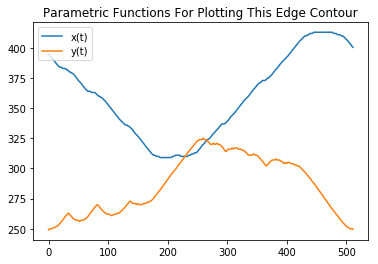


----------------------------------------------------------------------------



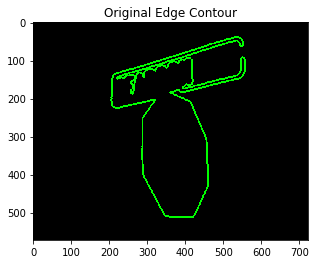

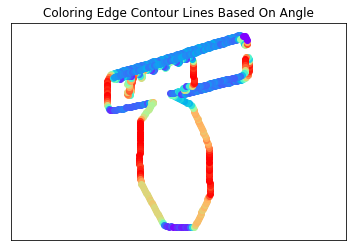

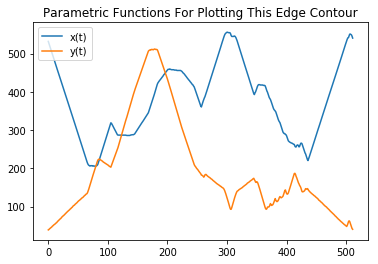


----------------------------------------------------------------------------



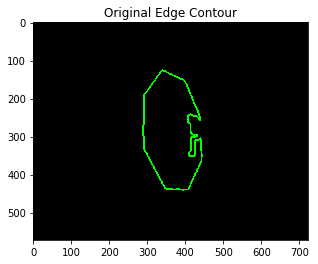

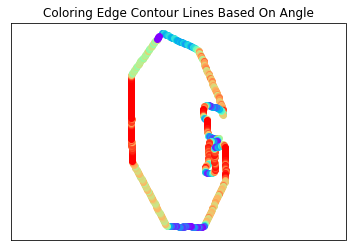

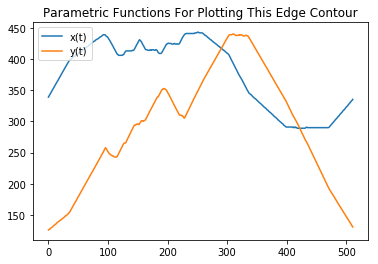


----------------------------------------------------------------------------



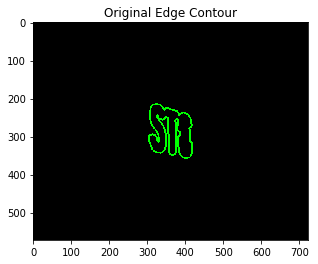

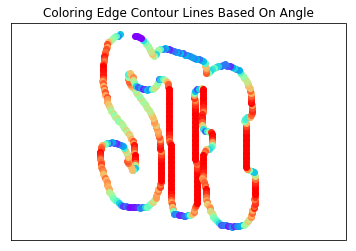

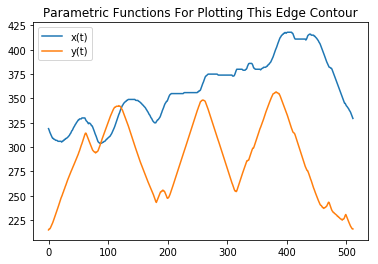


----------------------------------------------------------------------------



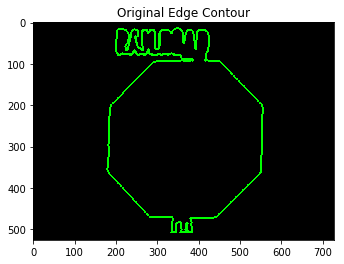

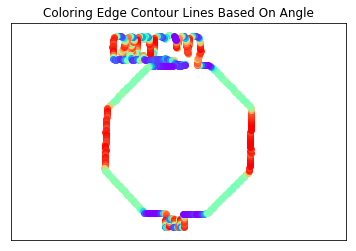

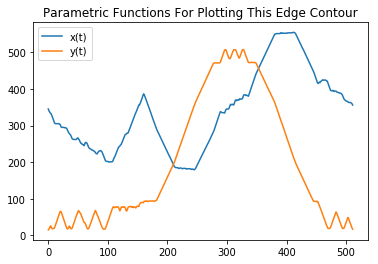


----------------------------------------------------------------------------



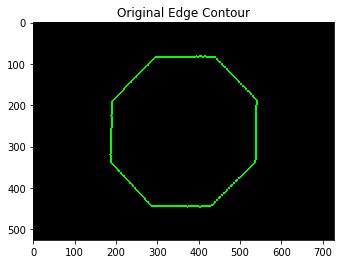

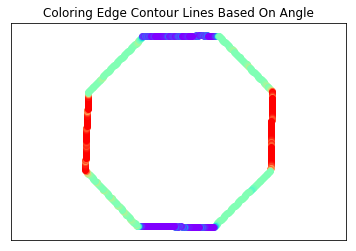

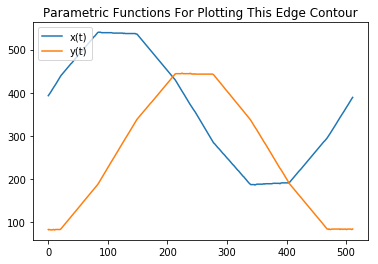


----------------------------------------------------------------------------



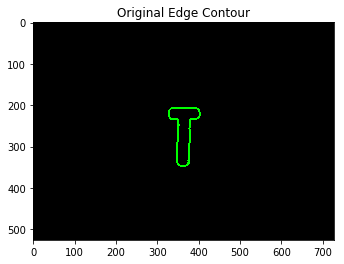

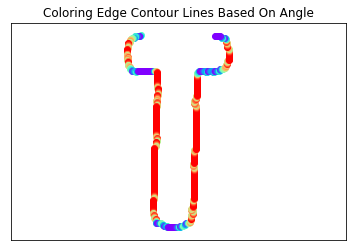

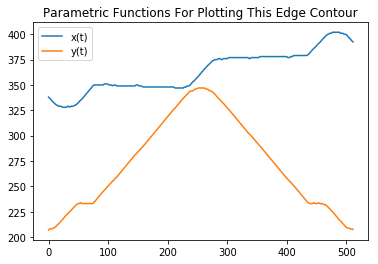


----------------------------------------------------------------------------



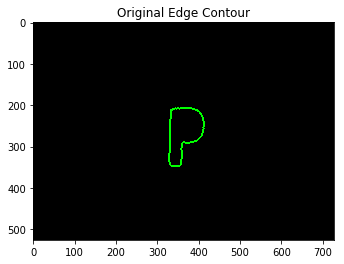

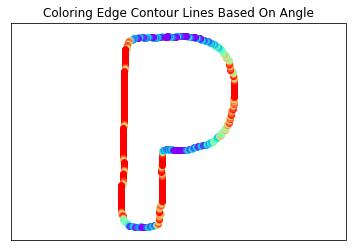

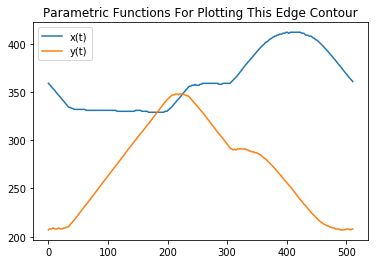


----------------------------------------------------------------------------



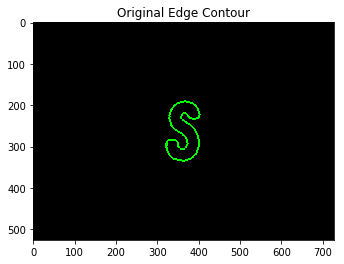

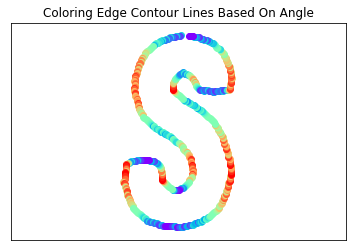

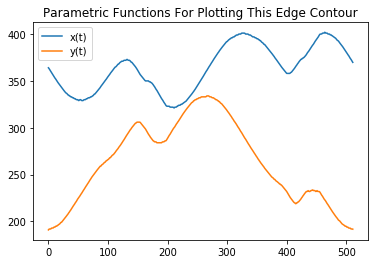


----------------------------------------------------------------------------



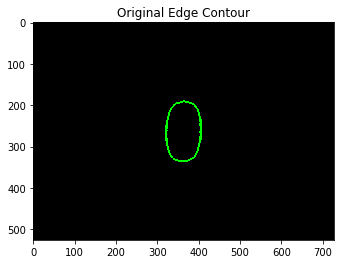

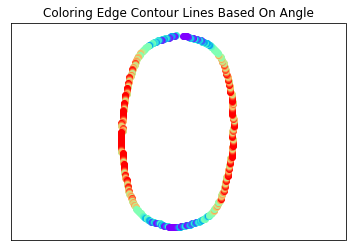

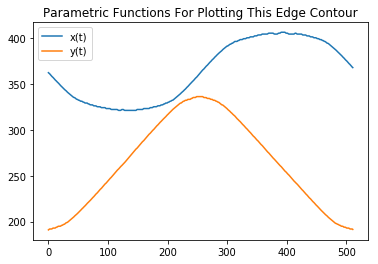


----------------------------------------------------------------------------



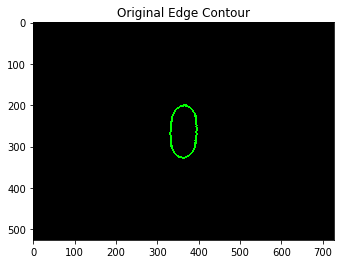

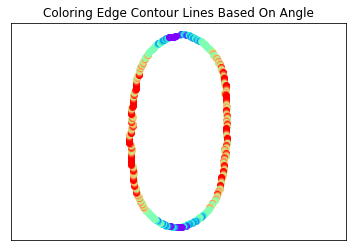

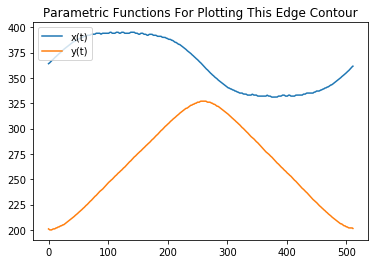


----------------------------------------------------------------------------



In [10]:
def getParametricX(contour):
    pts = []
    for pt in contour:
        #print "{}, {}".format(pt[0][0], pt[0][1])
        pts.append(pt[0][0])
    return np.array(pts)

def getParametricY(contour):
    pts = []
    for pt in contour:
        #print "{}, {}".format(pt[0][0], pt[0][1])
        pts.append(pt[0][1])
    return np.array(pts)

def constSampling(contour):
    pts_x = []
    pts_y = []
    distances = []
    running_dist = 0.00
    prev_pt_x = None
    prev_pt_y = None
    for pt in contour:
        pts_x.append(pt[0][0])
        pts_y.append(pt[0][1])
        if prev_pt_x is None:
            prev_pt_x = pt[0][0]
            prev_pt_y = pt[0][1]
        
        running_dist += np.sqrt((pt[0][0] - prev_pt_x) ** 2 + (pt[0][1] - prev_pt_y) ** 2)
        distances.append(running_dist)
        prev_pt_x = pt[0][0]
        prev_pt_y = pt[0][1]
    
    pts_x = np.array(pts_x)
    pts_y = np.array(pts_y)
    distances = np.array(distances)
    linear_x = np.interp(np.arange(0, running_dist, running_dist / 512.0), distances, pts_x)
    linear_y = np.interp(np.arange(0, running_dist, running_dist / 512.0), distances, pts_y)
    
    return linear_x, linear_y

def calcAngle(delta_x, delta_y):
    if delta_y == 0:
        return 0.0
    if delta_x == 0:
        return 0.5*np.pi
    else:
        return abs(np.arctan(float(delta_y) / float(delta_x)))
        

def averageAngle(x_t, y_t):
    angles = []
    for i in range(0, len(x_t)):
        if (i+4) >= len(x_t):
            angles.append(0.0)
            continue
        this_angle = calcAngle(x_t[i+4] - x_t[i], y_t[i+4] - y_t[i])
        this_angle += calcAngle(x_t[i+3] - x_t[i], y_t[i+3] - y_t[i])
        this_angle += calcAngle(x_t[i+2] - x_t[i], y_t[i+2] - y_t[i])
        this_angle += calcAngle(x_t[i+1] - x_t[i], y_t[i+1] - y_t[i])
        this_angle = this_angle / 4.0
        angles.append(this_angle)
    return np.array(angles)
            
        

index = 0
for eim in new_images:
    cont, hier = cv2.findContours(cv2.cvtColor(eim, cv2.COLOR_BGR2GRAY), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in cont:
        if cv2.contourArea(c) < 5000: #Tunable parameter
            continue
        new_image = np.zeros(eim.shape, images[0].dtype)
        """
        Draw the contours such that the center-of-mass is at eim.shape[X]/2, eim.shape[Y]/2
        """
        m = cv2.moments(c)
        cx = int(m['m10']/m['m00'])
        cy = int(m['m01']/m['m00'])
        #print "{},{}".format(cx, cy)
        
        proper_cx = int(eim.shape[1]/2)
        proper_cy = int(eim.shape[0]/2)
        #print "{},{}".format(proper_cx, proper_cy)
        
        diff_x = proper_cx - cx
        diff_y = proper_cy - cy
        #print "Move by {},{}".format(diff_x, diff_y)
        
        cv2.drawContours(new_image, [c + np.array([[[diff_x,diff_y]]])], -1, (0, 255, 0), 3)
        #plt.subplot('131')
        plt.title("Original Edge Contour")
        plt.imshow(new_image)
        plt.show()
        
        parametric_x, parametric_y = constSampling(c + np.array([[[diff_x,diff_y]]]))
        point_angles = averageAngle(parametric_x, parametric_y)
        
        #plt.plot(range(len(c)), getParametricX(c), range(len(c)), getParametricY(c))
        #plt.subplot('132')
        #plt.scatter(parametric_x, -1*parametric_y)
        #plt.plot(parametric_x, -1*parametric_y)
        plt.title('Coloring Edge Contour Lines Based On Angle')
        for pti in range(len(parametric_x)):
            plt.scatter(parametric_x[pti], -1*parametric_y[pti], c=cm.rainbow(point_angles[pti] / (0.5*np.pi)))
        plt.gca().axis('equal')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        #plt.subplot('133')
        plt.title("Parametric Functions For Plotting This Edge Contour")
        plt.plot(range(len(parametric_x)), parametric_x, label="x(t)")
        plt.plot(range(len(parametric_y)), parametric_y, label="y(t)")
        plt.legend(loc='upper left')
        plt.show()
        
        print("")
        print("----------------------------------------------------------------------------")
        print("")
        
        #print(len(c))
    #print len(cont)